In [6]:
import tensorflow as tf

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from src.simulation.battery_env import BatteryEnv

env = BatteryEnv()
num_actions = 3
state_shape = env._get_state().shape


In [8]:
def build_q_network():
    model = tf.keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=state_shape),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_actions, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

q_model = build_q_network()


In [9]:
from collections import deque
import random

replay_buffer = deque(maxlen=2000)

def remember(state, action, reward, next_state, done):
    replay_buffer.append((state, action, reward, next_state, done))


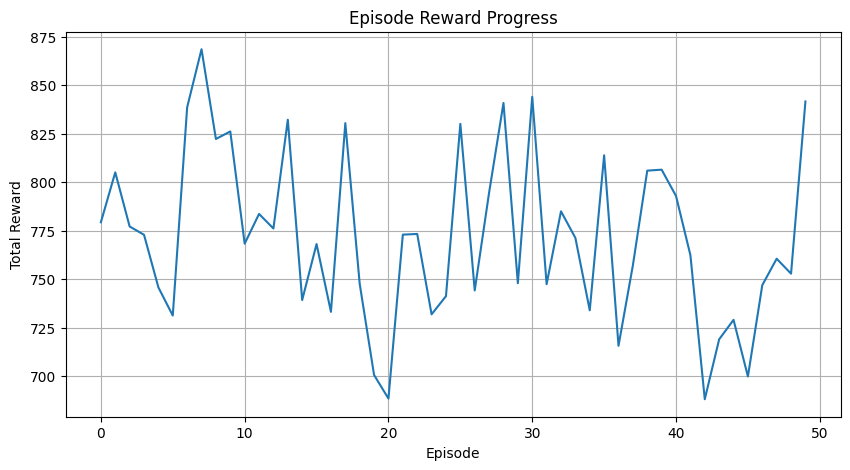

Episode 50/50 - Reward: 841.5 - Epsilon: 0.36


In [10]:
# TRAINING LOOP

import random
from collections import deque
import matplotlib.pyplot as plt
from IPython.display import clear_output

episode_rewards = []
epsilon = 1.0
epsilon_min = 0.1
epsilon_decay = 0.98
gamma = 0.95
batch_size = 16
episodes = 50

for ep in range(episodes):
    state = env.reset()
    total_reward = 0
    done = False

    while not done:
        # Choose action (epsilon-greedy)
        if np.random.rand() < epsilon:
            action = np.random.randint(num_actions)
        else:
            q_vals = q_model.predict(state.reshape(1, -1), verbose=0)
            action = np.argmax(q_vals[0])

        # Step in environment
        next_state, reward, done, _ = env.step(action)
        replay_buffer.append((state, action, reward, next_state, done))
        state = next_state
        total_reward += reward

        # Train only if buffer is ready
        if len(replay_buffer) >= batch_size:
            minibatch = random.sample(replay_buffer, batch_size)
            states = np.array([m[0] for m in minibatch])
            next_states = np.array([m[3] for m in minibatch])
            
            targets = q_model.predict(states, verbose=0)
            next_qs = q_model.predict(next_states, verbose=0)

            for i, (s, a, r, s_next, d) in enumerate(minibatch):
                targets[i][a] = r if d else r + gamma * np.max(next_qs[i])

            q_model.fit(states, targets, epochs=1, verbose=0)

    # Decay exploration
    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    episode_rewards.append(total_reward)

    # Live plot every 10 episodes
    if (ep + 1) % 10 == 0:
        clear_output(wait=True)
        plt.figure(figsize=(10, 5))
        plt.plot(episode_rewards)
        plt.title("Episode Reward Progress")
        plt.xlabel("Episode")
        plt.ylabel("Total Reward")
        plt.grid(True)
        plt.show()

    print(f"Episode {ep+1}/{episodes} - Reward: {total_reward:.1f} - Epsilon: {epsilon:.2f}")

   # WITH VS WITHOUT AI TEST
 # WITH VS WITHOUT AI TEST
def test_policy(q_model, agent_control=True):
    env = BatteryEnv()
    state = env.reset()
    battery_levels = []
    grid_draws = []

    for _ in range(96):  # one day of 15-min steps
        if agent_control:
            q_vals = q_model.predict(state.reshape(1, -1), verbose=0)
            action = np.argmax(q_vals[0])
        else:
            action = 0  # no AI — do nothing (hold)

        next_state, reward, done, _ = env.step(action)
        battery_levels.append(env.battery_kwh)
        # Grid draw = demand – solar (if not discharged)
        grid_draws.append(max(0, env.forecast_kw - env.solar_kw) if action == 0 else reward)
        state = next_state

        if done:
            break

    return battery_levels, grid_draws




In [11]:
battery_ai, grid_ai = test_policy(q_model, agent_control=True)
battery_noai, grid_noai = test_policy(q_model, agent_control=False)

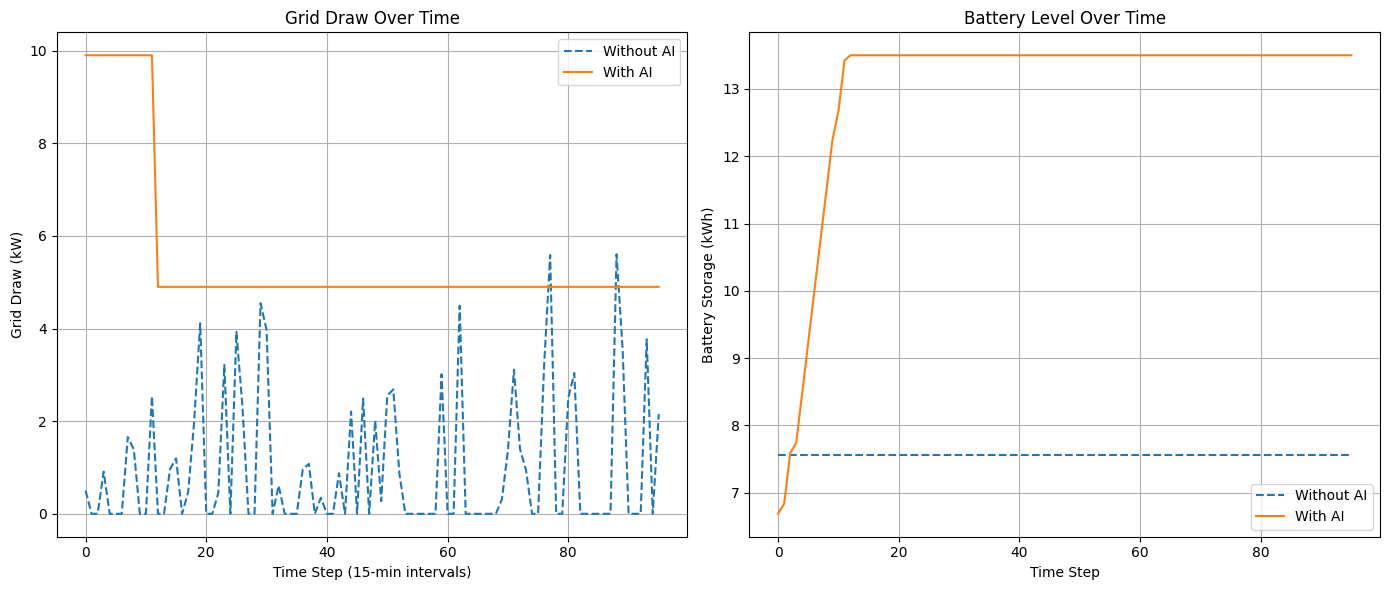

In [12]:
plt.figure(figsize=(14, 6))

# Grid draw comparison
plt.subplot(1, 2, 1)
plt.plot(grid_noai, label='Without AI', linestyle='--')
plt.plot(grid_ai, label='With AI', linestyle='-')
plt.title("Grid Draw Over Time")
plt.xlabel("Time Step (15-min intervals)")
plt.ylabel("Grid Draw (kW)")
plt.legend()
plt.grid(True)

# Battery level comparison
plt.subplot(1, 2, 2)
plt.plot(battery_noai, label='Without AI', linestyle='--')
plt.plot(battery_ai, label='With AI', linestyle='-')
plt.title("Battery Level Over Time")
plt.xlabel("Time Step")
plt.ylabel("Battery Storage (kWh)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("ai_vs_noai_comparison.png")
plt.show()
